# Fetching Data from PubMed (Entrez API)

In [ ]:
!



In [ ]:
import os
import pandas as pd
import time
import random
from Bio import Entrez
from urllib.error import HTTPError

# Set your email for NCBI Entrez API
Entrez.email = "your_email@example.com"

# CSV files with diseases output from CTD-ID:
# python Python/main_gba.py --adj_path ../data/target_disease/cor_matrix_99.csv --s_nodes ../data/target_disease/ad_cor_20.csv
# python Python/main_gba.py --adj_path ../data/target_disease/cor_matrix_99.csv --s_nodes ../data/target_disease/childhoodcancer_cor_20.csv
# python Python/main_gba.py --adj_path ../data/target_disease/cor_matrix_99.csv --s_nodes ../data/target_disease/chd_cor_20.csv
gba_ranks_files = {
    'Alzheimer disease': '../data/target_disease/ad_cor_20_0.955_gba_ranks.csv',
    'Childhood cancer': '../data/target_disease/childhoodcancer_cor_20_0.946_gba_ranks.csv',
    'Congenital heart disease': '../data/target_disease/chd_cor_20_0.888_gba_ranks.csv'
}

s_files = {
    'Alzheimer disease': '../data/target_disease/ad_cor_20.csv',
    'Childhood cancer': '../data/target_disease/childhoodcancer_cor_20.csv',
    'Congenital heart disease': '../data/target_disease/chd_cor_20.csv'
}

all_files = [s_files, gba_ranks_files, gba_ranks_files]
subset = ['Disease_module', 'Top', 'Random']

TOP_DISEASE_NUM = 1000

# Function to search PubMed with retries
def search_pubmed_with_retry(disease1, disease2="childhood cancer", max_results=20_000, retries=5, delay=0.5):
    query = f"{disease1} AND {disease2}"
    
    for attempt in range(retries):
        try:
            handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
            record = Entrez.read(handle)
            handle.close()
            num_articles = len(record["IdList"])
            print(f"🔍 {disease1}: Found {num_articles} articles.")
            return num_articles
        
        except HTTPError as e:
            print(f"⚠️ HTTPError for query '{query}': {e}. Retrying in {delay} seconds...")
        except Exception as e:
            print(f"⚠️ Unexpected error for query '{query}': {e}. Retrying in {delay} seconds...")
        
        time.sleep(delay)
        delay *= 2  # Exponential backoff
    
    print(f"❌ Failed to fetch results for '{query}' after {retries} retries.")
    return 0  # Return 0 if all retries fail

# Fetch PubMed Data and Save to CSV
for csv_files, info in zip(all_files, subset):
    for explored_disease, path in csv_files.items():
        # Read first column (disease names)
        df = pd.read_csv(path, usecols=[0])
        if info == 'Disease_module':
            disease_list = df.iloc[:, 0].dropna().tolist()
        elif info == 'Top':
            disease_list = df.iloc[:, 0].dropna().tolist()[:TOP_DISEASE_NUM]
        else:  # Random subset
            disease_list = df.iloc[:, 0].dropna().tolist()[100:]
            disease_list = random.sample(disease_list, min(TOP_DISEASE_NUM, len(disease_list)))

        # Format disease names
        disease_list = [x.replace('_', ' ').replace('.', ' ') for x in disease_list]

        # Query PubMed for each disease
        results = []
        for disease in disease_list:
            num_articles = search_pubmed_with_retry(disease, explored_disease)
            results.append({"Disease": disease, "Articles": num_articles})
            time.sleep(0.3)  # Sleep to prevent rate limiting

        # Convert to DataFrame and save results
        df_results = pd.DataFrame(results)
        df_results.to_csv(f"{explored_disease.replace(' ', '_')}_pubmed_results_{info}.csv", index=False)

print("✅ Data fetching complete. CSV files saved.")


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


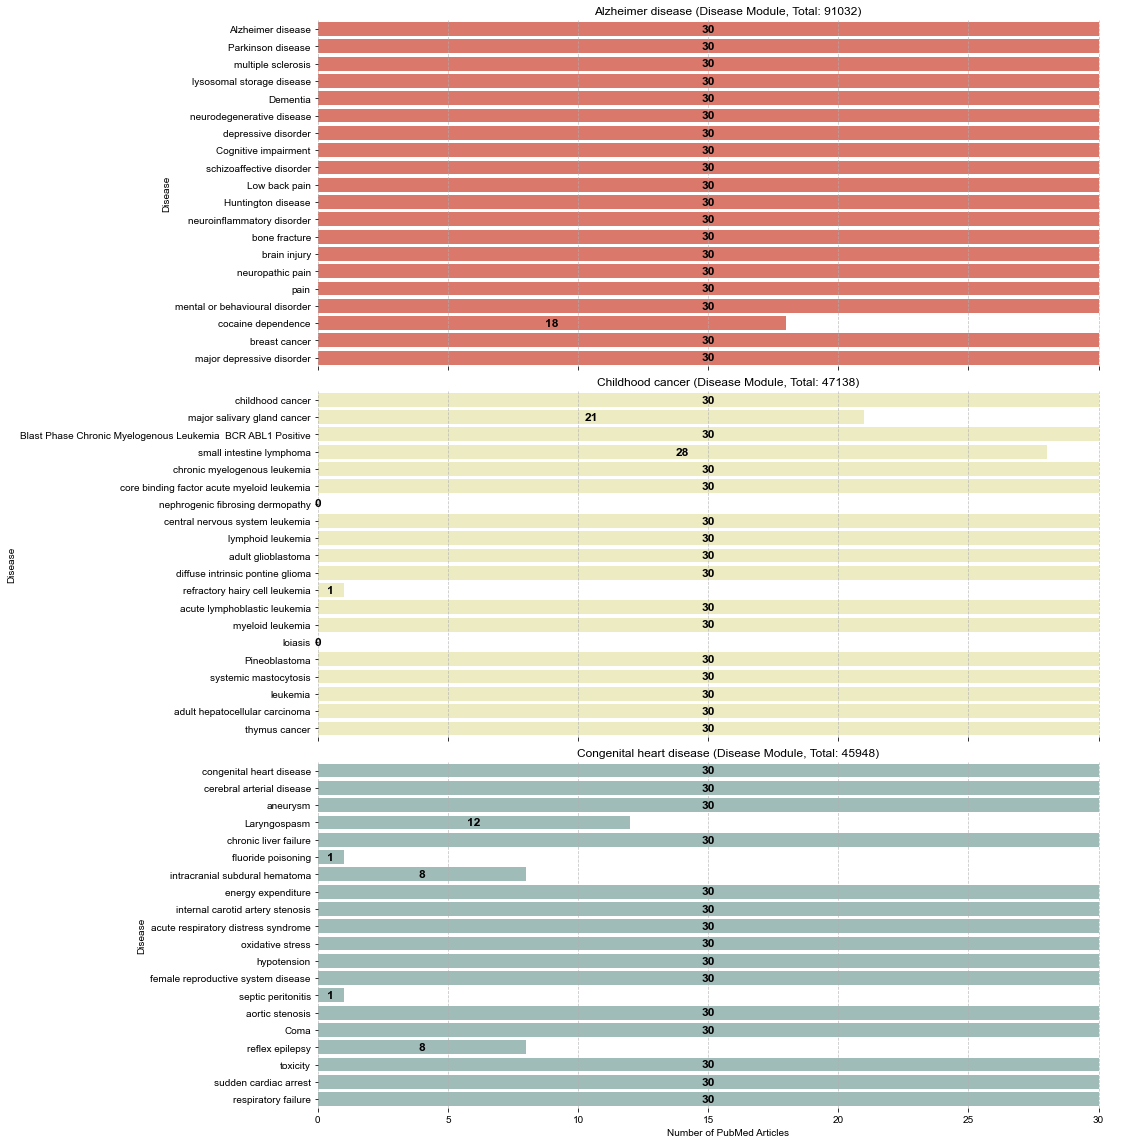

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


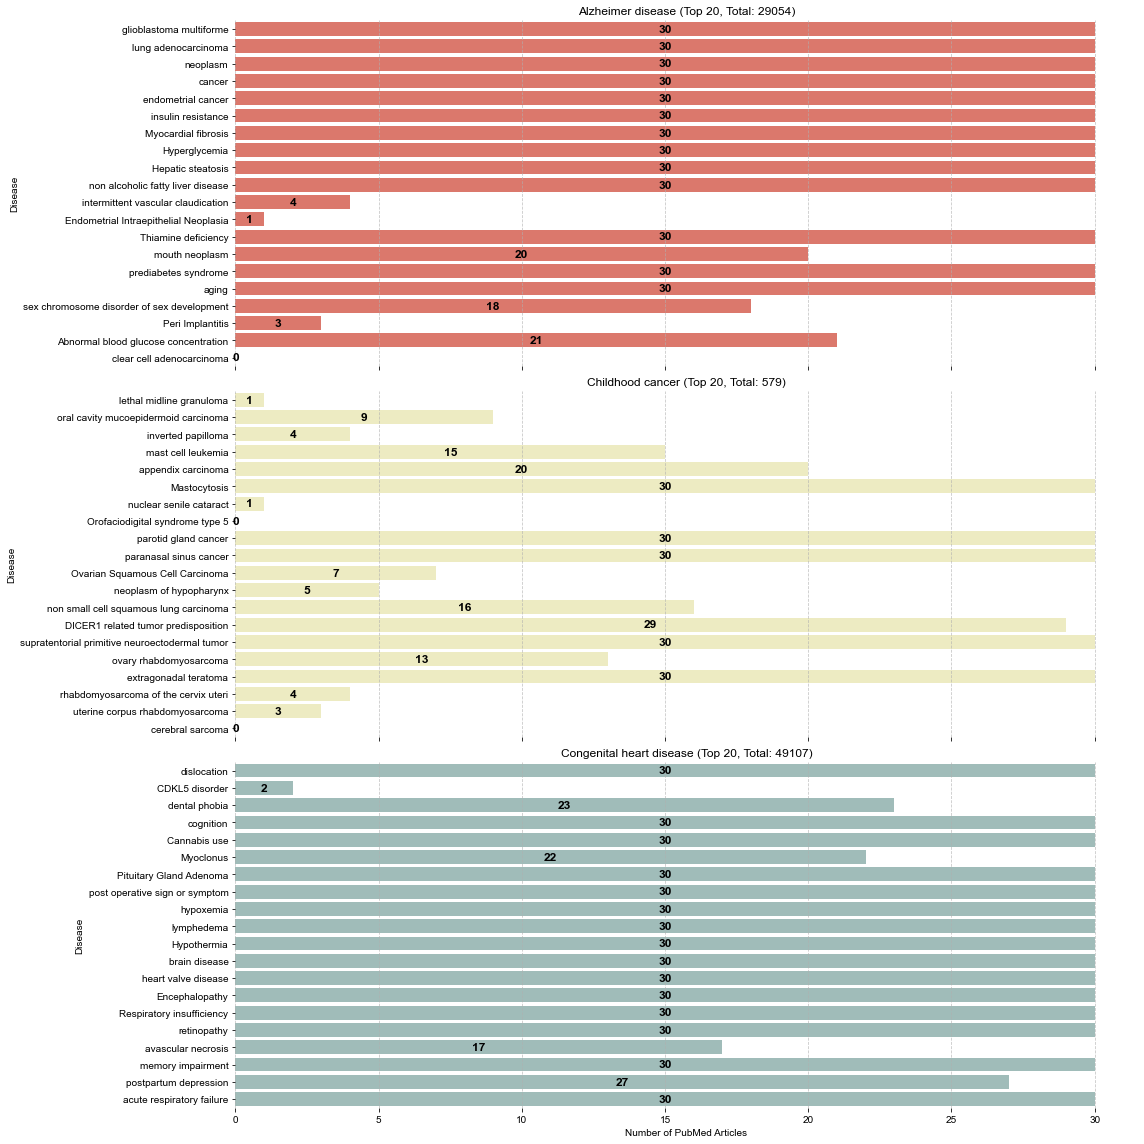

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


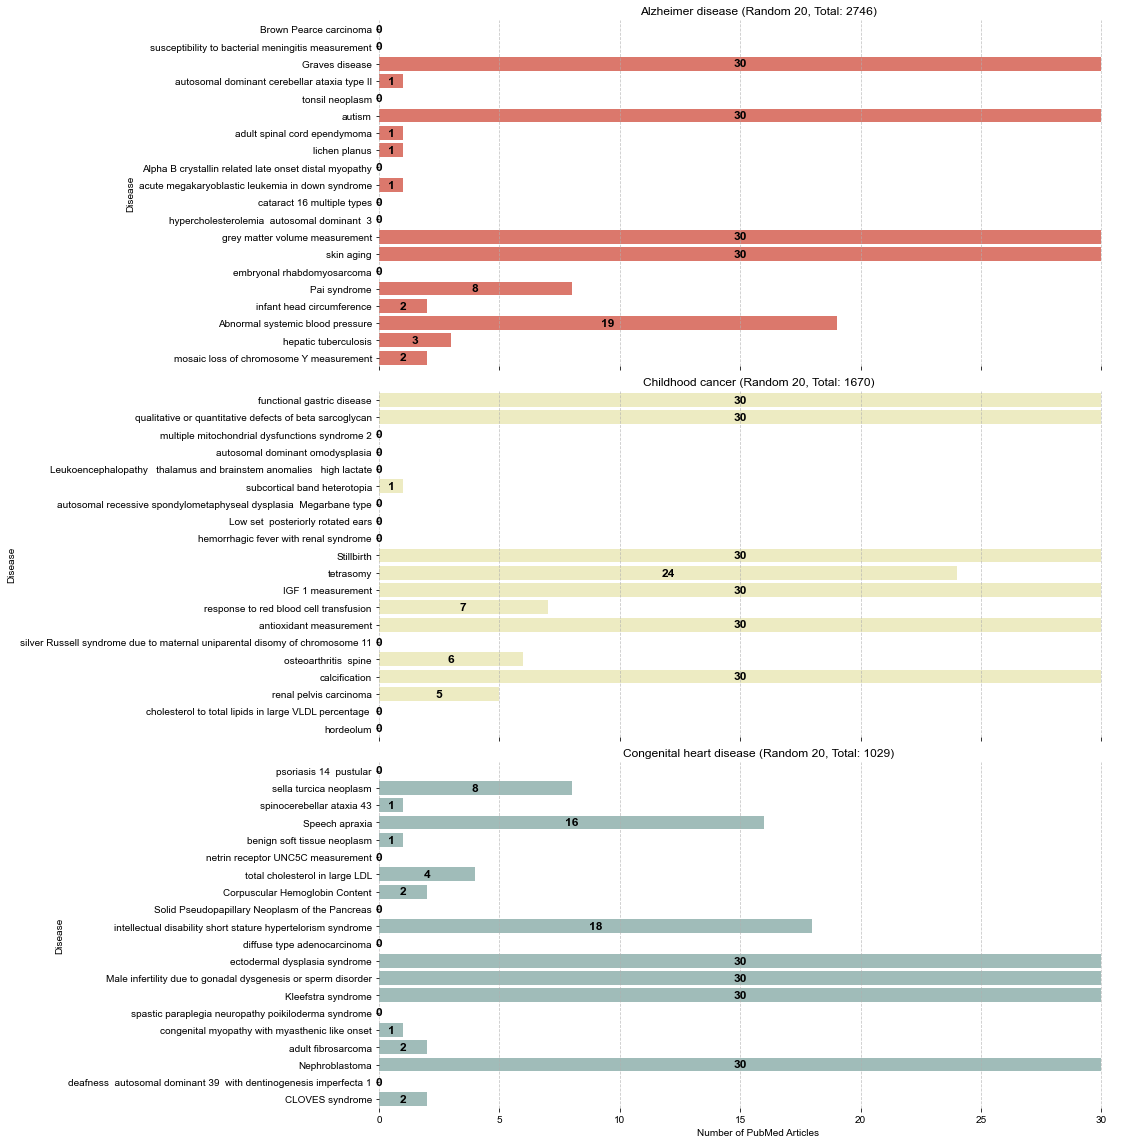

✅ Visualization complete.


In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

TOP_DISEASE_NUM = 20
plt.rcParams['font.family'] = 'Arial'

# Visualization
for csv_files, info in zip(all_files, subset):
    fig, axes = plt.subplots(3, 1, figsize=(16, 16), sharex=True)
    colors = ['#ed6a5a', '#f4f1bb', '#9bc1bc']

    for i, (explored_disease, path) in enumerate(csv_files.items()):
        ax = axes[i]

        # Load results from CSV
        sufix = '_1000' if info != 'Disease_module' else ''
        df_results = pd.read_csv(f"../data/target_disease/{explored_disease.replace(' ', '_')}_pubmed_results_{info}{sufix}.csv").head(TOP_DISEASE_NUM)

        # Get total number of articles
        top_total = df_results["Articles"].sum()
        df_results.loc[:, 'Articles'] = df_results['Articles'].apply(lambda x: 30 if x > 30 else x)

        # Plot results
        sns.barplot(data=df_results, x="Articles", y="Disease", color=colors[i], ax=ax)
        ax.set_xlabel("Number of PubMed Articles")
        ax.set_ylabel("Disease")
        ax.grid(axis="x", linestyle="--", alpha=0.7)
        ax.set_yticks(ax.get_yticks())  # Ensure ticks are set before setting labels
        ax.set_yticklabels(df_results['Disease'])
        ax.set_frame_on(False)

        if info == 'Disease_module':
            ax.set_title(f"{explored_disease} (Disease Module, Total: {top_total})")
        elif info == 'Top':
            ax.set_title(f"{explored_disease} (Top {TOP_DISEASE_NUM}, Total: {top_total})")
        else:  # Random subset
            ax.set_title(f"{explored_disease} (Random {TOP_DISEASE_NUM}, Total: {top_total})")

        # Add value labels
        for p in ax.patches:
            width = p.get_width()
            ax.text(width / 2, p.get_y() + p.get_height() / 2, f'{int(width)}',
                    ha='center', va='center', fontsize=12, color='black', fontweight='bold')

        print('-' * 80)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f"pubmed_results_{info}.png", dpi=200)
    plt.show()

print("✅ Visualization complete.")


Alzheimer disease --------------------------------------------------------------------------------
Total articles for Top: 640851
Total articles for Random: 185745
Childhood cancer --------------------------------------------------------------------------------
Total articles for Top: 464203
Total articles for Random: 102298
Congenital heart disease --------------------------------------------------------------------------------
Total articles for Top: 801664
Total articles for Random: 188652


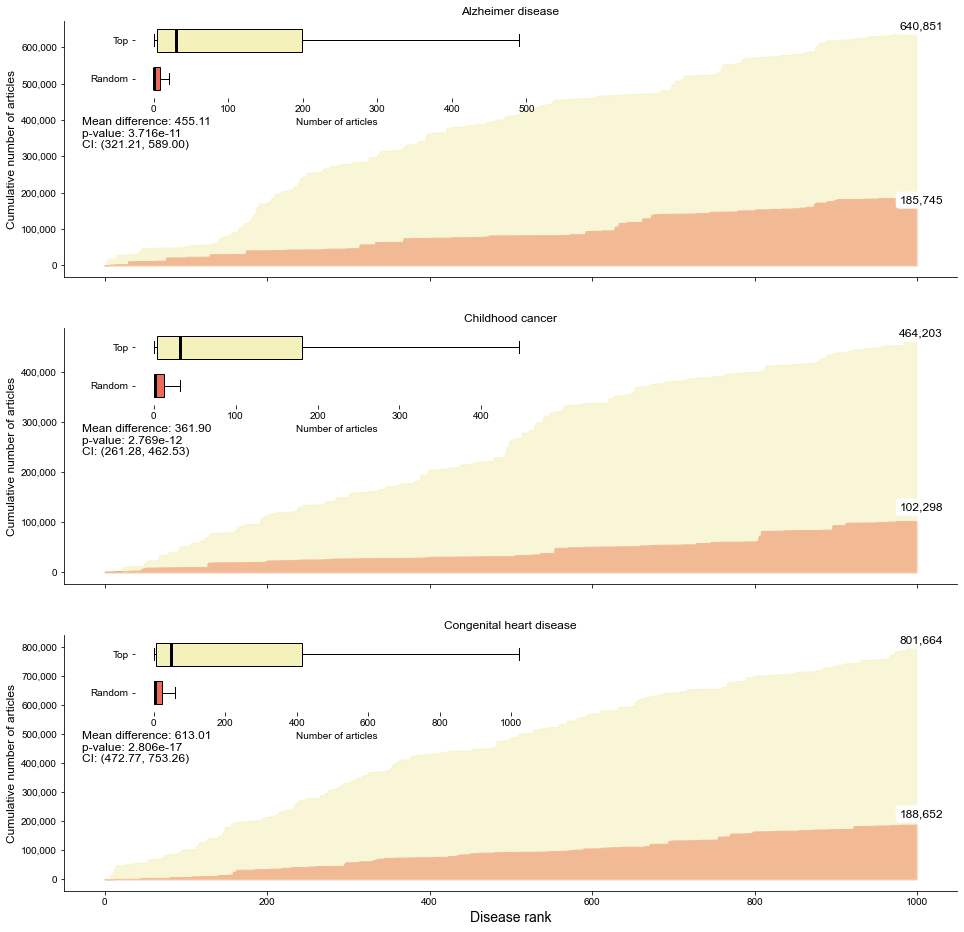

In [119]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

# Set the font to Arial for everything
plt.rcParams['font.family'] = 'Arial'

fig, axes = plt.subplots(3, 1, figsize=(16, 16), sharex=True)
random_color = '#ed6a5a'
top_color = '#f4f1bb'
for i, explored_disease in enumerate(csv_files.keys()):
    print(explored_disease, '-'*80)
    df_all = pd.DataFrame()
    ax = axes[i]
    
    # Stacked plot for Top and Random
    for info in ['Top', 'Random']:
        df_results = pd.read_csv(f"../data/target_disease/{explored_disease.replace(' ', '_')}_pubmed_results_{info}_1000.csv")
        df_all[info] = df_results['Articles']
        
        # Get total number of articles
        total_articles = df_results["Articles"].sum()
        print(f"Total articles for {info}: {total_articles}")
        
        # Annotate the total number of articles for each category (Top/Random)
        ax.annotate(f"{total_articles:,}", 
                    xy=(0.96, 0.98 if info == 'Top' else 0.3), 
                    xycoords="axes fraction", 
                    ha="center", 
                    va="center", 
                    fontsize=12, 
                    color='black', 
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
    
    df_all['Top_Cumulative'] = df_all['Top'].cumsum()
    df_all['Random_Cumulative'] = df_all['Random'].cumsum()
    
    # Fill between for stacked plot
    ax.fill_between(df_all.index, 0, df_all['Random_Cumulative'], color=random_color, alpha=1.0, label="Random")
    ax.fill_between(df_all.index, 0, df_all['Top_Cumulative'], color=top_color, alpha=0.6, label="Top")

    formatter = FuncFormatter(lambda x, _: f"{x:,.0f}")
    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylabel('Cumulative number of articles', size=12)
    
    # *************** Create horizontal boxplots inside each subplot
    ax_inset = ax.inset_axes([0.08, 0.7, 0.45, 0.3])  # Positioning the inset boxplot (x, y, width, height)
    
    # Plot the boxplots with wider boxes
    box = ax_inset.boxplot([df_all['Random'], df_all['Top']], vert=False, patch_artist=True, showfliers=False,
                           widths=0.6,  # Make boxes wider (adjust as needed)
                           medianprops=dict(color='black', linewidth=3))  # Median line color
    ax_inset.spines['top'].set_visible(False)
    ax_inset.spines['right'].set_visible(False)
    ax_inset.spines['left'].set_visible(False)
    ax_inset.spines['bottom'].set_visible(False)
    
    # Color the boxes manually
    box['boxes'][1].set_facecolor(top_color)  # Top box color
    box['boxes'][0].set_facecolor(random_color)  # Random box color
    # Adding labels for the boxplot
    ax_inset.set_yticklabels(['Random', 'Top'])
    ax_inset.set_xlabel("Number of articles")
    # *******************************************************************

    # T-test between Top and Random distributions
    t_stat, p_value = stats.ttest_ind(df_all['Top'], df_all['Random'], equal_var=False)
    
    # Calculate Confidence Interval for the difference in means
    mean_diff = np.mean(df_all['Top']) - np.mean(df_all['Random'])
    std_diff = np.sqrt(np.var(df_all['Top'], ddof=1) / len(df_all['Top']) + np.var(df_all['Random'], ddof=1) / len(df_all['Random']))
    ci_low = mean_diff - 1.96 * std_diff
    ci_high = mean_diff + 1.96 * std_diff

    # Display Mean Difference, p-value, and Confidence Interval on the plot
    ax.annotate(f"Mean difference: {mean_diff:.2f}\np-value: {p_value:.3e}\nCI: ({ci_low:.2f}, {ci_high:.2f})", 
                xy=(0.02, 0.56), 
                xycoords="axes fraction", 
                ha="left", 
                va="center", 
                fontsize=12, 
                color='black', 
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
    
    ax.set_title(explored_disease)
    # Remove legend
    ax.legend().set_visible(False)

# Remove the box around the subplots
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.xlabel("Disease rank", size=14)
plt.savefig(f"pubmed_cum_results_{info}.png", dpi=200, bbox_inches='tight')
plt.show()
